# Exploratory Data Analysis

## Required Packages and Libraries

To properly reproduce these visualizations you will need to use the following packages and libraries:

In [1]:
import pandas as pd               #Used for data manipulation, tidying data and conditional statements
bokeh.io.output_notebook()        #Enable viewing Bokeh plots in the notebook and interactive
import matplotlib.pyplot as plt   #Data visualization dictionary
import numpy as np  

NameError: name 'bokeh' is not defined

## Data Prep & Cleaning

Since our focus is on how campaigns affected sales the following data frames were imported into Python:

In [13]:
from completejourney_py import get_data

cj_data = get_data()
transactions = cj_data['transactions']
demographics = cj_data['demographics']
products = cj_data['products']
campaigns = cj_data['campaigns']

Once the completejourney data was imported into Python, the next step was to tidy the data. We were interested in discovering trends related to campaigns and how it affected sales. Therefore, we started with merging campaigns, demographics, transactions and products. 

In [14]:
# merge campaigns, demographics, transactions on household_id
df1 = (
    campaigns
    .merge(demographics, how='inner', on='household_id')
    .merge(transactions, how='inner', on='household_id')
)

# merge
df2 = (
   df1
   .merge(products, how='inner', on='product_id')
)

# merge
coupons = (
    cj_data['coupon_redemptions']
    .merge(cj_data['demographics'], how='inner', on='household_id')
    .merge(cj_data['campaign_descriptions'], how='inner', on='campaign_id')
)

#merge
coupon_transactions = (
    cj_data['coupon_redemptions']
    .merge(cj_data['coupons'], how='inner', on='campaign_id')
)

In [15]:
datetimes = pd.to_datetime(coupon_transactions['redemption_date'])
coupon_transactions['day'] = datetimes.dt.day
coupon_transactions['month'] = datetimes.dt.month
coupon_transactions['year'] = datetimes.dt.year

coupon_redemptions = (
coupon_transactions
    .groupby('month')['redemption_date'].count()
)
coupon_redemptions = coupon_redemptions.to_frame()

## Visualizations

### Which campaigns sold the most products?

The first step we took to evaluate the effectiveness of campaigns was to find out the total sales achieved through each campaign.

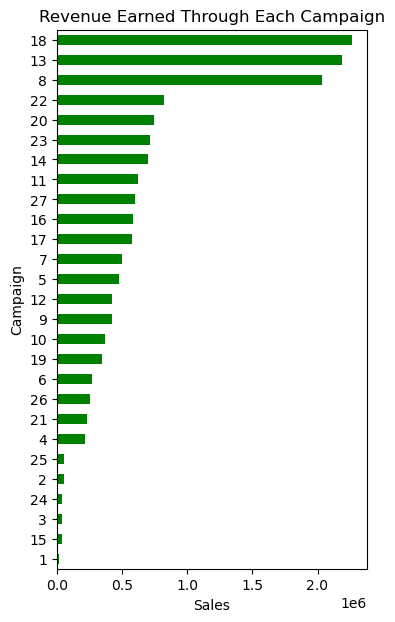

In [16]:
df_campaigns = df2.groupby(['campaign_id'],as_index=False).agg({'sales_value':'sum'}).sort_values(by = 'sales_value', ascending=False)

ax =(df_campaigns
    .sort_values('sales_value')
    .plot(x='campaign_id', y='sales_value', kind='barh', title='Revenue Earned Through Each Campaign', figsize=(4,7),color='green', legend = False, xlabel='Campaign')
);
ax.set_xlabel('Sales');

Looking at the bar chart above it is clear that campaigns 18, 13 and 8 generated the highest sales. Let's take a deeper dive into these three campaigns.

### Coupon Redemptions Over Time

We can now look at what times of the year coupons are most used.

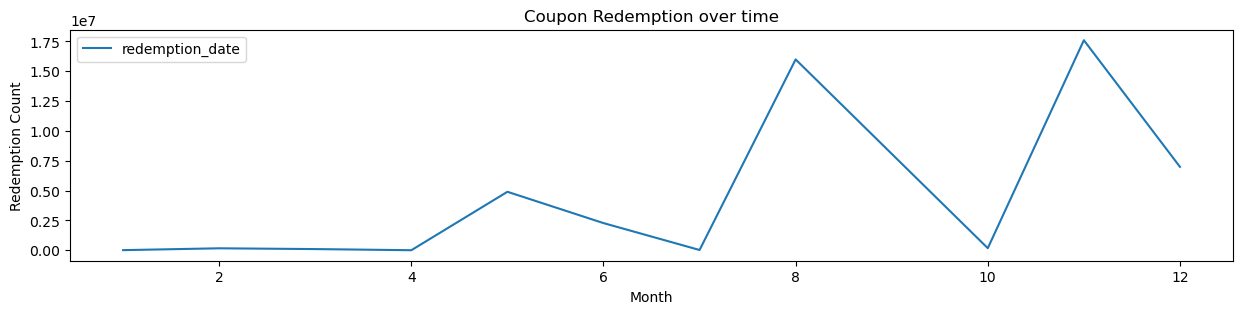

In [17]:
coupon_redemptions.plot(
    kind='line',
    title='Coupon Redemption over time',
    ylabel='Redemption Count',
    xlabel='Month',
    figsize=(15,3)
);

### Coupon Redemptions by Age Group

Now that we can see which campaigns are most effective, we can look at what customers are most valuable to target these campaigns towards.

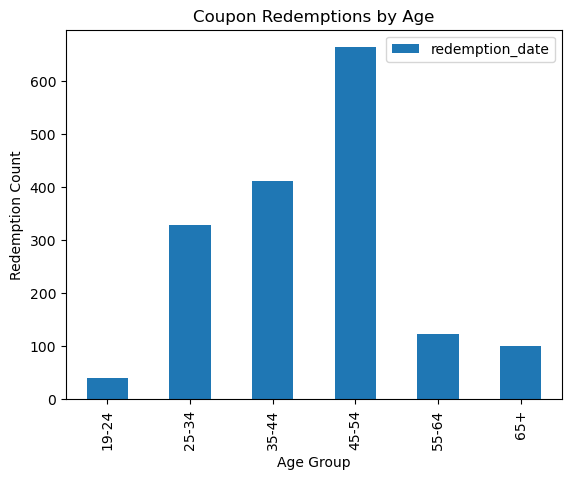

In [18]:
redemptions = (
coupons
    .groupby('age')['redemption_date'].count()
)
redemptions = redemptions.to_frame()
redemptions.plot(
    kind='bar',
    title='Coupon Redemptions by Age',
    ylabel='Redemption Count',
    xlabel='Age Group',
);

Sales patterns for campaigns 18, 13 and 8 according to each age group was observed.

In [29]:
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.transform import jitter
from bokeh.layouts import row

# create color mapper
color_mapper = bokeh.transform.factor_cmap(
    'age', 
    palette=['red', 'blue','green','orange','purple','grey'], 
    factors=cam18_age['age'].unique()
    )

# plot 7
source1 = ColumnDataSource(cam18_age)
ax7 = figure(sizing_mode="stretch_width",
    frame_height=1000,
           x_axis_type='datetime',
           title="Campaign 18 sales by each Age Group Over the Year")

ax7.scatter(x='Transaction_Date', y=jitter('sales_value', width=0.6, range=ax7.y_range),  source=source1,
         fill_color=color_mapper,
    line_color=color_mapper,
    legend_field='age'        
)
ax7.yaxis.axis_label = 'Sales'
ax7.legend.title = "Age Group"

# display legend in top left corner (default is top right corner)
ax7.legend.location = "top_left"

tooltips = [("Sales","@sales_value")]
hover = bokeh.models.HoverTool(tooltips=tooltips, mode='mouse')
ax7.add_tools(hover)

# plot 8
source2 = ColumnDataSource(cam13_age)
ax8 = figure(sizing_mode="stretch_width",
    frame_height=1000,
           x_axis_type='datetime',
           title="Campaign 13 sales by each Age Group Over the Year")

ax8.scatter(x='Transaction_Date', y=jitter('sales_value', width=0.6, range=ax8.y_range),  source=source2,
         fill_color=color_mapper,
    line_color=color_mapper
)

tooltips = [("Sales","@sales_value")]
hover = bokeh.models.HoverTool(tooltips=tooltips, mode='mouse')
ax8.add_tools(hover)

# plot 9
source3 = ColumnDataSource(cam8_age)
ax9 = figure(sizing_mode="stretch_width",
    frame_height=1000,
           x_axis_type='datetime',
           title="Campaign 8 sales by each Age Group Over the Year")

ax9.scatter(x='Transaction_Date', y=jitter('sales_value', width=0.6, range=ax9.y_range),  source=source3,
         fill_color=color_mapper,
    line_color=color_mapper
)

tooltips = [("Sales","@sales_value")]
hover = bokeh.models.HoverTool(tooltips=tooltips, mode='mouse')
ax9.add_tools(hover)

# put the results in a row and show
bokeh.io.show(row(ax7,ax8,ax9))

From the two above plots, it is clear that age group 45-54 brings in the most revenue for each campaign and redeems the most coupons. Age groups 55 and above and the youngest age group (19-24) are in the lower sales range while 25-44 age groups are in the middle. Regork should prioritize the 45-54 age group when introducing new campaigns in order to increase sales and capitalize on dollars invested.

### Sales Value by Demographic

In [43]:
married_value = (
    df1
    .groupby(['marital_status'],as_index=False)
    .agg({'sales_value': 'mean'})
)
married_value

,marital_status,sales_value
0,Married,3.286185
1,Unmarried,3.077016


<AxesSubplot:xlabel='marital_status'>

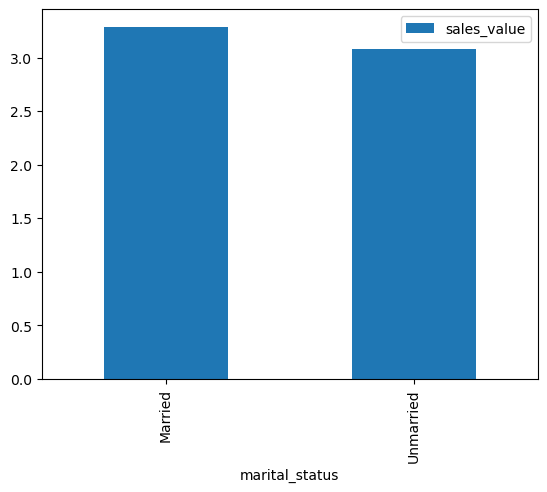

In [44]:
married_value.plot.bar(x='marital_status', y='sales_value')

In [45]:
salary_value = (
    df1
    .groupby(['income'],as_index=False)
    .agg({'sales_value': 'mean'})
    .sort_values('sales_value')
)
salary_value

,income,sales_value
2,15-24K,2.910096
6,25-34K,2.983829
8,35-49K,2.992532
11,Under 15K,2.996083
9,50-74K,3.163346
10,75-99K,3.395323
1,125-149K,3.432552
3,150-174K,3.451712
0,100-124K,3.520661
7,250K+,3.707235


<AxesSubplot:xlabel='income'>

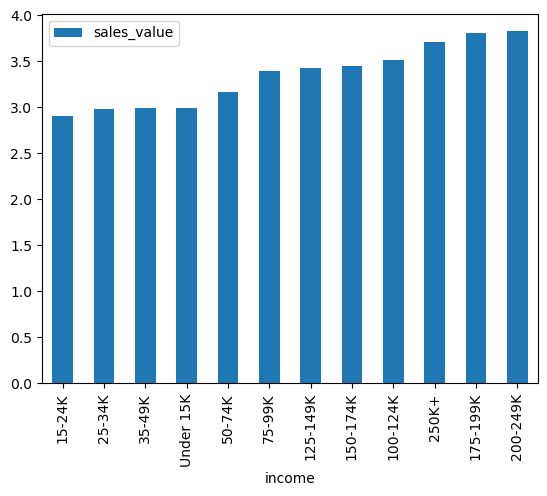

In [46]:
salary_value.plot.bar(x='income', y='sales_value')

In [47]:
homeowner_value = (
    df1
    .groupby(['home_ownership'],as_index=False)
    .agg({'sales_value':'mean'})
)
homeowner_value

,home_ownership,sales_value
0,Homeowner,3.306641
1,Probable Homeowner,2.739900
2,Probable Renter,2.850118
3,Renter,2.985395


<AxesSubplot:xlabel='home_ownership'>

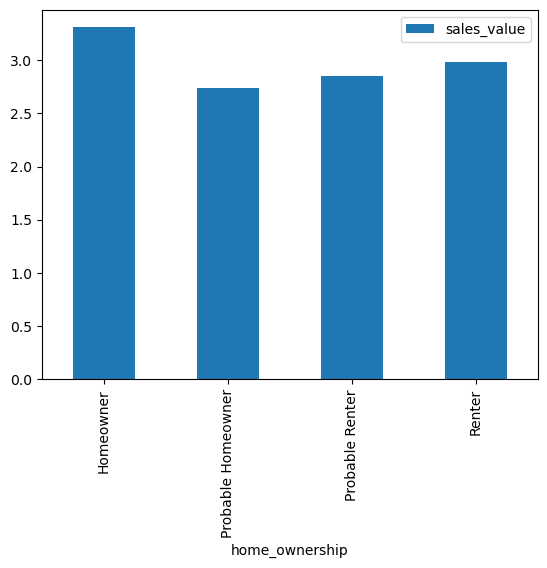

In [48]:
homeowner_value.plot.bar(x='home_ownership', y='sales_value')

## Environment

In [40]:
%load_ext watermark
%watermark -v -p jupyterlab

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

jupyterlab: 3.4.4

